## 뉴스검색_최종
- 뉴스 데이터 : 뉴스데이터_전체통합_수정_20210729.csv 
- 단어빈도 데이터 : 제목/내용 일별/월별.csv
- 상장법인목록.csv
- 주가확인 차트 v3(주가 기간내 모든 날짜 생성)

In [1]:
import sys
import os
from functools import reduce
import operator
import pandas as pd
import datetime
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings(action='ignore')
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# 검색관련 기능

# v2: 20210729 제목/내용 케이스 확장

def findkeyword_v2(df,keyword,제목5내용6=5): 
    if 제목5내용6 ==5:
        findstr = '제목단어'
    if 제목5내용6 ==6:
        findstr = '내용단어'
    return df[findstr].str.contains(keyword) # 단어가 포함된 뉴스 전부
def findkeywordtf(df,keyword):
    return (df['단어'] == keyword)
def findcorpnews(df,corpname):
    return df['종목명'].str.contains(corpname) # 기업명이 있을 경우 기업조건 추가해 검색

def 키워드제외기업(키워드,제목5내용6=5):
    if 제목5내용6 == 5:   # 제목
        키워드제외기업tempdf = 통합일별TF_제목.copy()
    if 제목5내용6 == 6:   # 내용
        키워드제외기업tempdf = 통합일별TF_내용.copy()
    TF비율 = 키워드제외기업tempdf[키워드제외기업tempdf['단어'].str.contains(키워드)].groupby('종목명').agg({'빈도':'sum'}) # 20210729 통합TF->통합일별TF->통합일별TF_제목/내용 수정
    TF비율.sort_values(by = '빈도', ascending=False, inplace=True)
    TF비율['비율'] = TF비율['빈도'] / TF비율['빈도'].sum() *100

    검색제외 = TF비율[(TF비율['빈도']<30)&(TF비율['비율']<2)] # 빈도수 30개이하인 것으로 테스트(예-웨스턴디지털) 
    return 검색제외.index.to_list()

# TOP20개 목록에 '주식종목'이 포함되어 있으면, 핵심키워드로 판단 > 종목코드 같이 출력
def 연관키워드_종목추출(TOP50keyword):
    종목리스트 = []
    Top50list = TOP50keyword.split(', ')
    corpdf = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0][['회사명','종목코드']] 
    for kw in list(Top50list):
    #     try:
        if kw == '현대차': 
            kw = '현대자동차'
        종목코드 = corpdf.query("회사명=='{}'".format(kw.upper())).종목코드.to_string(index=False).zfill(6)
        if 종목코드 != 'Series([], )':
            종목리스트.append(f'{kw}({종목코드})')
    return ', '.join(종목리스트)
#             print(f'{kw}({종목코드})')
#     except:
#         pass

def findticker(namelist):
    codelist = []
    df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0][['회사명','종목코드']]
    for corpname in namelist:
        corpname = corpname.replace('POSCO','포스코').replace('현대차','현대자동차')
        code = df.query("회사명=='{}'".format(corpname))['종목코드'].to_string(index=False)
        codelist.append(code)
    codelist = [x.zfill(6) for x in codelist]
    return codelist


In [3]:
# chart - 주가 흐름 확인(종가 기준)
def 군집확인_종가scaling(종목코드): # minmax   / standard
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    df = fdr.DataReader(종목코드,'20200720','20210723')
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df = pd.DataFrame(df_scaled, index=df.index , columns=df.columns)
    df = df['Close']
    
    return df

In [4]:
# chart - 일자별 주가와 단어 빈도수 확인

from matplotlib import dates
from matplotlib.dates import date2num, DayLocator, DateFormatter

def 주가확인_v3(종목이름,영향단어,제목5내용6=5, 주가=None, 빈도='pink'):
    if 제목5내용6 == 5:   # 제목
        주가확인tempTF = 통합일별TF_제목.copy()
    if 제목5내용6 == 6:   # 내용
        주가확인tempTF = 통합일별TF_내용.copy()

    tempTF = 주가확인tempTF.groupby('종목명').get_group(종목이름.upper()).groupby('단어').get_group(영향단어.lower()) # 20210729 통합TF->통합일별TF->통합일별TF_제목/내용 수정
    tempTF = tempTF[(tempTF['날짜']>=start_date)&(tempTF['날짜']<=end_date)]

    # 주가데이터 
    종목코드 = corpdf[corpdf.회사명==종목이름]['종목코드'].values[0]
    주가df = fdr.DataReader(종목코드,start_date,end_date)
    주가df.reset_index(inplace=True)
    주가df.rename(columns={'Date':'날짜'},inplace=True)
    주가df['날짜'] =주가df['날짜'].apply(lambda x:  str(pd.to_datetime(x).date()))

    # 날짜데이터
    dates = pd.date_range(start_date,end_date)
    전체날짜 = pd.DataFrame(dates, columns=['날짜'])
    전체날짜['날짜'] =전체날짜['날짜'].apply(lambda x:  str(pd.to_datetime(x).date()))


    # 날짜데이터, 주가데이터, TF데이터 병합
    viewdf = pd.merge(주가df[['날짜','Close']],tempTF[['날짜','빈도']],on='날짜',how='outer')
    viewdf = pd.merge(viewdf[['날짜','Close','빈도']],전체날짜['날짜'],on='날짜',how='outer')
    viewdf.sort_values('날짜',inplace=True)
    viewdf['Close'].fillna(method='ffill',inplace=True)
    viewdf['Close'].fillna(method='bfill',inplace=True)
    viewdf['빈도'].fillna(0, inplace=True)

    # 차트 생성
    keepdates = viewdf['날짜'].tolist()
    viewdf['날짜'] = date2num(pd.to_datetime(viewdf['날짜']).tolist())   # 정상날짜 나오게함.

    fig, ax1 = plt.subplots() 
    plt.rcParams['figure.figsize'] = (12, 8)
    ax1.bar('날짜', '빈도', data=viewdf, color=빈도)#,marker='o')
    ax1.legend([f'단어빈도 <{영향단어}>'], loc = 'upper left')
    ax2 = ax1.twinx()
    ax2.plot('날짜','Close',data=viewdf,marker='o', alpha= 0.7,c=주가)
    ax2.legend([f'{종목이름} 주가'], loc = 'upper right')
    # ax2.xaxis.set_major_locator(dates.AutoDateLocator())
    ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.xlabel(종목이름)
    plt.show()
    
    viewdf['날짜'] = keepdates # 뉴스 확인위해 날짜 복원
    viewdf.head()


## 데이터 불러오기

In [5]:
# 뉴스 데이터
newsDF = pd.read_csv('뉴스데이터_전체통합_수정_20210729.csv')

In [6]:
newsDF.날짜.max()

'2021-07-24 18:00:00'

In [7]:
# 제목단어 null 데이터 삭제하고 다시 붙여넣기--------------------------------------그냥 drop / 의미있는기사 3건정도 되나, '명사'추출이 안되는 단어
newsDF.drop(newsDF[newsDF['제목단어'].isnull()].index, axis=0, inplace=True)
newsDF.isna().sum().sum()

0

In [8]:
newsDF.shape

(61544, 10)

In [9]:
# 종목코드 추출용 - 상장법인목록

corpdf = pd.read_csv('상장법인목록.csv')
corpdf.head()
corpdf['종목코드'] = corpdf['종목코드'].apply(lambda x: str(x).zfill(6))
corpdf.head()
corpdf.to_csv('상장법인목록.csv',index=False)

### 통합 TF 

In [10]:
# 통합 TF 데이터 생성

통합일별TF_제목 = pd.read_csv('통합일별TF_제목기준(아모레수정)_20210729.csv')
통합일별TF_내용 = pd.read_csv('통합일별TF_내용기준(아모레수정)_20210729.csv')

In [11]:
print('-제목-' , '\t\t','-내용-')
print(통합일별TF_제목.shape,통합일별TF_내용.shape)

-제목- 		 -내용-
(276165, 4) (4555259, 4)


In [12]:
# # 월별과 크로스체크 - 가공 잘 됐는지 ----------------확인 완료
# tm= 통합월별TF_내용.groupby('단어').agg({'빈도':'sum'})
# tm.sort_values('빈도',ascending=False,inplace=True)
# tm.head(10)

# td= 통합일별TF.groupby('단어').agg({'빈도':'sum'})
# td.sort_values('빈도',ascending=False,inplace=True)
# td.head(10)

### 통합 TF 조회 - 2가지(제목 / 내용)

In [13]:
제목TF = 통합일별TF_제목.groupby(['종목명','단어']).agg({'빈도':'sum'}) 
제목TF.sort_values(['종목명','빈도'],ascending=False, inplace=True)

# 특정 기업에서 빈도 높은 단어 보고싶을 때
# 기업명 = '포스코' # 주의: 현대차->현대자동차, 알파벳->대문자, 네이버->NAVER, POSCO->포스코
# 제목TF.loc[기업명].head() # 특정기업

In [14]:
내용TF = 통합일별TF_내용.groupby(['종목명','단어']).agg({'빈도':'sum'}) 
내용TF.sort_values(['종목명','빈도'],ascending=False, inplace=True)
# 내용TF.head()

# 특정 기업에서 빈도 높은 단어 보고싶을 때
# 기업명 = '포스코' # 주의: 현대차->현대자동차, 알파벳->대문자, 네이버->NAVER, POSCO->포스코
# 내용TF.loc[기업명].head() # 특정기업

# 검색

샘플: 검색조건
1. 기업: SK텔레콤
2. 키워드: 플랫폼
3. 기간: 20210301 20210331

In [15]:
# 검색 1 - 제목TF 기준


# -------------------------------------------------------------------------------------------------------------1) 데이터 입력
start_date = '2020-07-01'
end_date = '2021-07-24'
start_month = pd.to_datetime(start_date).month
end_month = pd.to_datetime(end_date).month

N = input('[검색어 개수] ')             #(키워드#v2) 키워드 입력받기)
if N:
    키워드 = [input('[검색어] ') for _ in range (int(N))]
else: 
    키워드 = []
    print('지정한 검색어가 없습니다.')
    
기업명 = input('[검색할 기업 이름] ').upper()




# -------------------------------------------------------------------------------------------------------------2) 뉴스 검색
뉴스df = newsDF.copy()[(newsDF['날짜']>=start_date)&(newsDF['날짜']<=end_date)]


#-------------------------------------------------------------------기업명 필터링
if len(기업명)>0:
    if 기업명 == '네이버':
        기업명 = 'NAVER'
    뉴스df = 뉴스df[findcorpnews(뉴스df,기업명)]
    print(f'검색 대상은 "{기업명}"입니다.')
else:
    print(f'검색 대상은 20개 전체 기업입니다.')

    
#--------------------------------------------------------------------키워드 필터링
for i in range(len(키워드)):                                                 
    뉴스df = 뉴스df[findkeyword_v2(뉴스df,키워드[i].upper(),5)]
    
#--------------------------------------------------------------------연관적은기업 필터링
try:
    droplist = []
    for key in 키워드:
        검색제외리스트 = 키워드제외기업(key,5)
        for corp in 검색제외리스트:
            droplist.append(뉴스df[findcorpnews(뉴스df,corp)].index.to_list())

    droplist = list(set(list(reduce(operator.add, droplist)))) # 검색에서 제외할 뉴스 인덱스
    print('\n -----------------------')
    print('기업필터링전기존검색뉴스',뉴스df.shape[0])    
    뉴스df.drop(index = droplist, axis=0, inplace=True)
    print('연관 낮은 기업 제거 후',뉴스df.shape[0],'\n -----------------------')
except:
    pass


#-------------------------------------------------------------------'시황'뉴스 필터링(종목 열거형 뉴스)
# df = df[~(df['제목'].str.contains('시황'))]
# # df = df[~(df['내용'].str.contains('종목'))]
# print('시황 제거 후',df.shape,'\n -----------------------')

뉴스df.reset_index(drop=True, inplace=True)


print('\n- - - - - - - 조건에 맞는 뉴스 검색 완료 - - - - - - -\n')
print(f'[검색된 뉴스 개수] {뉴스df.shape[0]} 건')
print(f'[검색된 뉴스 기간] {pd.to_datetime(뉴스df.날짜.min()).date()}~{pd.to_datetime(뉴스df.날짜.max()).date()}')
#-------------------------------------------------------------------뉴스데이터 검색될 경우 TF 생성
try: 
    뉴스tf = TF생성_조회용_v2(뉴스df,5)
    단어필터링 = 뉴스tf.query("(단어=='지난해')|(단어=='올해')|(단어=='올해')|(단어=='통해')| (단어=='시장')| (단어=='기업')| (단어=='기자')|\
                        (단어=='지난')|(단어=='때문')|(단어=='그룹')").index
    뉴스tf.drop(단어필터링, axis=0, inplace=True) # 연관20에서제거목적
    
    # 키워드 언급 횟수 계산    
    keytfsum = 0
    keyfreq = []

    for i in range(len(키워드)):
        findata = 뉴스tf[findkeywordtf(뉴스tf,키워드[i].lower())]
        if findata.shape[0] != 0:
            keyfreq.append(f'{findata.iloc[0,0]} : {findata.iloc[0,1]}')
            findata = findata.iloc[0,1]
            keytfsum += findata
    
    TOP20keyword = ", ".join(뉴스tf[:20].단어.tolist())
    연관종목 = 뉴스tf[:50].단어.tolist()
    종목리스트 = 연관키워드_종목추출(TOP20keyword)    

    print(f'[검색된 기사 내 키워드 빈도수] 총 {keytfsum} 건 => {", ".join(keyfreq)}') # 정확히 일치하는 키워드만 보여줌
    print(f'[{키워드} 연관 기사 발행 기업] {뉴스df.종목명.nunique()}개 => "{", ".join(뉴스df.종목명.unique())}" \n') # 비율도같이추가
    print(f'[키워드 관련 주식종목] {종목리스트}')
    print(f'[연관 키워드 TOP20] {TOP20keyword}\n')
    print('\n- - - - - - - 검색 조건에 맞는 전체 기사를 추출합니다 - - - - - - -\n')
    뉴스df.sort_values('날짜', inplace=True)

except:
    print('검색된 뉴스가 없습니다.')
뉴스df.head()
뉴스df[['종목명','제목','출처','날짜','내용','URL','주가']].head()

[검색어 개수]  1
[검색어]  배터리
[검색할 기업 이름]  


검색 대상은 20개 전체 기업입니다.

 -----------------------
기업필터링전기존검색뉴스 2217
연관 낮은 기업 제거 후 2116 
 -----------------------

- - - - - - - 조건에 맞는 뉴스 검색 완료 - - - - - - -

[검색된 뉴스 개수] 2116 건
[검색된 뉴스 기간] 2020-07-23~2021-07-22
검색된 뉴스가 없습니다.


,종목명,제목,출처,날짜,내용,URL,주가
0,삼성SDI,"삼성SDI ""전고체 배터리 2027년 상용화""",한국경제,2020-07-23 17:17:00,이재용·정의선이 기다리는 그 기술리튬보다 용량 크고 안정적양산 시점 처음으로 제시삼...,https://finance.naver.com/item/news_read.nhn?a...,385500.0
1,삼성SDI,"전기차 개화기 준비하는 삼성SDI…""꿈의 배터리, 2027년 이후 상용화 기대""",머니투데이,2020-07-23 18:31:00,[머니투데이 김성은 기자] /사진=삼성SDI삼성SDI가 리튬이온 배터리 대비 안전성...,https://finance.naver.com/item/news_read.nhn?a...,385500.0
2,SK이노베이션,"LG화학-SK이노베이션, 배터리 분쟁 결말 D-70..쟁점은",이데일리,2020-07-27 13:09:00,- 10월 5일 美 ITC 최종 판결 앞두고 양측 물밑 협상 지속- 배상 수준 놓고...,https://finance.naver.com/item/news_read.nhn?a...,131000.0
3,LG화학,"LG화학-SK이노베이션, 배터리 분쟁 결말 D-70..쟁점은",이데일리,2020-07-27 13:09:00,- 10월 5일 美 ITC 최종 판결 앞두고 양측 물밑 협상 지속- 배상 수준 놓고...,https://finance.naver.com/item/news_read.nhn?a...,517000.0
4,삼성SDI,"“TWS 코인셀 배터리, 하반기부터 공급 시작”-삼성SDI 컨콜",이데일리,2020-07-28 13:52:00,[이데일리 김종호 기자] “TWS용 코인셀 배터리는 고객 승인을 마치고 하반기부터 ...,https://finance.naver.com/item/news_read.nhn?a...,393000.0


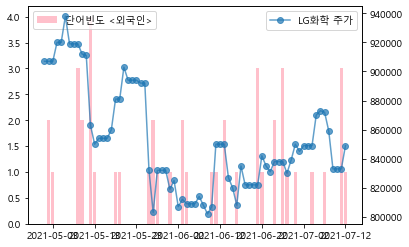

In [16]:
# 주가&키워드빈도 확인----------------------------

종목이름 = 'LG화학'
start_date = '2021-05-01'
end_date = '2021-07-12'
영향단어 = '외국인'
빈도 = 'pink'
주가 = 'blue'
주가확인_v3(종목이름,영향단어, 제목5내용6=5) # 제목TF 기준 5 / 내용TF 기준 6

In [17]:
# 검색 2 - 내용TF 기준


# -------------------------------------------------------------------------------------------------------------1) 데이터 입력
start_date = '2020-07-01'
end_date = '2021-07-24'
start_month = pd.to_datetime(start_date).month
end_month = pd.to_datetime(end_date).month

N = input('[검색어 개수] ')             #(키워드#v2) 키워드 입력받기)
if N:
    키워드 = [input('[검색어] ') for _ in range (int(N))]
else: 
    키워드 = []
    print('지정한 검색어가 없습니다.')
    
기업명 = input('[검색할 기업 이름] ').upper()




# -------------------------------------------------------------------------------------------------------------2) 뉴스 검색
뉴스df_내용 = newsDF.copy()[(newsDF['날짜']>=start_date)&(newsDF['날짜']<=end_date)]


#-------------------------------------------------------------------기업명 필터링
if len(기업명)>0:
    if 기업명 == '네이버':
        기업명 = 'NAVER'
    뉴스df_내용 = 뉴스df_내용[findcorpnews(뉴스df_내용,기업명)]
    print(f'검색 대상은 "{기업명}"입니다.')
else:
    print(f'검색 대상은 20개 전체 기업입니다.')

    
#--------------------------------------------------------------------키워드 필터링
for i in range(len(키워드)):                                                 
    뉴스df_내용 = 뉴스df_내용[findkeyword_v2(뉴스df_내용,키워드[i].upper(),6)]
    
#--------------------------------------------------------------------연관적은기업 필터링
try:
    droplist = []
    for key in 키워드:
        검색제외리스트 = 키워드제외기업(key,6)
        for corp in 검색제외리스트:
            droplist.append(뉴스df_내용[findcorpnews(뉴스df_내용,corp)].index.to_list())

    droplist = list(set(list(reduce(operator.add, droplist)))) # 검색에서 제외할 뉴스 인덱스
    print('\n -----------------------')
    print('기업필터링전기존검색뉴스',뉴스df_내용.shape[0])    
    뉴스df_내용.drop(index = droplist, axis=0, inplace=True)
    print('연관 낮은 기업 제거 후',뉴스df_내용.shape[0],'\n -----------------------')
except:
    pass


#-------------------------------------------------------------------'시황'이라는 단어가 포함된 주식종목 열거형 뉴스 필터링
# df = df[~(df['제목'].str.contains('시황'))]
# # df = df[~(df['내용'].str.contains('종목'))]
# print('시황 제거 후',df.shape,'\n -----------------------')

뉴스df_내용.reset_index(drop=True, inplace=True)


print('\n- - - - - - - 조건에 맞는 뉴스 검색 완료 - - - - - - -\n')
print(f'[검색된 뉴스 개수] {뉴스df_내용.shape[0]} 건')
print(f'[검색된 뉴스 기간] {pd.to_datetime(뉴스df_내용.날짜.min()).date()}~{pd.to_datetime(뉴스df_내용.날짜.max()).date()}')
#-------------------------------------------------------------------뉴스데이터 검색될 경우 TF 생성
try: 
    뉴스tf_내용 = TF생성_조회용_v2(뉴스df_내용,6)
    단어필터링 = 뉴스tf_내용.query("(단어=='지난해')|(단어=='올해')|(단어=='올해')|(단어=='통해')| (단어=='시장')| (단어=='기업')| (단어=='기자')|\
                        (단어=='지난')|(단어=='때문')|(단어=='그룹')").index
    뉴스tf_내용.drop(단어필터링, axis=0, inplace=True) # 연관20에서제거목적
    
    # 키워드 언급 횟수 계산    
    keytfsum = 0
    keyfreq = []

    for i in range(len(키워드)):

        findata = 뉴스tf_내용[findkeywordtf(뉴스tf_내용,키워드[i].lower())]
    #     print(findata)
        if findata.shape[0] != 0:
            keyfreq.append(f'{findata.iloc[0,0]} : {findata.iloc[0,1]}')
            findata = findata.iloc[0,1]
            keytfsum += findata
    
    TOP20keyword = ", ".join(뉴스tf_내용[:20].단어.tolist())
    연관종목 = 뉴스tf_내용[:50].단어.tolist()
    종목리스트 = 연관키워드_종목추출(TOP20keyword)    

    print(f'[검색된 기사 내 키워드 빈도수] 총 {keytfsum} 건 => {", ".join(keyfreq)}') # 정확히 일치하는 키워드만 보여줌
    print(f'[{키워드} 연관 기사 발행 기업] {뉴스df_내용.종목명.nunique()}개 => "{", ".join(뉴스df_내용.종목명.unique())}" \n') # 비율도같이추가
    print(f'[키워드 관련 주식종목] {종목리스트}')
    print(f'[연관 키워드 TOP20] {TOP20keyword}\n')
    print('\n- - - - - - - 검색 조건에 맞는 전체 기사를 추출합니다 - - - - - - -\n')
    뉴스df_내용.sort_values('날짜', inplace=True)

except:
    print('검색된 뉴스가 없습니다.')
뉴스df_내용[['종목명','제목','출처','날짜','내용','URL','주가']].head()

[검색어 개수]  1
[검색어]  배터리
[검색할 기업 이름]  


검색 대상은 20개 전체 기업입니다.

- - - - - - - 조건에 맞는 뉴스 검색 완료 - - - - - - -

[검색된 뉴스 개수] 7451 건
[검색된 뉴스 기간] 2020-07-23~2021-07-23
검색된 뉴스가 없습니다.


,종목명,제목,출처,날짜,내용,URL,주가
0,아모레퍼시픽,[유안타증권 주간추천주]‘높아진 회복 가시성’…삼성전자·SK이노·아모레퍼시픽,이데일리,2020-07-25 00:00:00,[이데일리 조용석 기자]◇코스피△삼성전자(005930)-3분기 메모리사업 실적은 상...,https://finance.naver.com/item/news_read.nhn?a...,163500.0
1,아모레퍼시픽,[유안타證 주간추천주]‘변곡점 예상’…삼성물산·아모레퍼시픽·SK이노,이데일리,2020-08-22 00:00:00,[이데일리 조용석 기자]◇코스피△삼성물산(028260)-삼성그룹 지배구조 개편 가능...,https://finance.naver.com/item/news_read.nhn?a...,174000.0
2,아모레퍼시픽,20년 터줏대감 삼성전자와 신흥주자 카카오에 동학개미 러브콜,중앙일보,2021-01-06 00:00:00,['시가총액 톱10' 20년 변천사 살펴보니]\t\t\t\t\t주식 시장은 국가 경...,https://news.joins.com/article/olink/23557939,200000.0
3,아모레퍼시픽,20년 터줏대감 삼성전자와 신흥주자 카카오에 동학개미 러브콜,중앙일보,2021-01-06 00:00:00,['시가총액 톱10' 20년 변천사 살펴보니]\t\t\t\t\t주식 시장은 국가 경...,https://news.joins.com/article/olink/23557939,200000.0
4,아모레퍼시픽,주요 기업들 4분기 실적 전망은…대형주 초강세 이어질까,머니투데이,2021-01-11 00:00:00,[머니투데이 김소연 기자] [[오늘의 포인트]] 지난해 4분기 기업들의 실적 발표 ...,http://news.moneytoday.co.kr/view/mtview.php?n...,196000.0


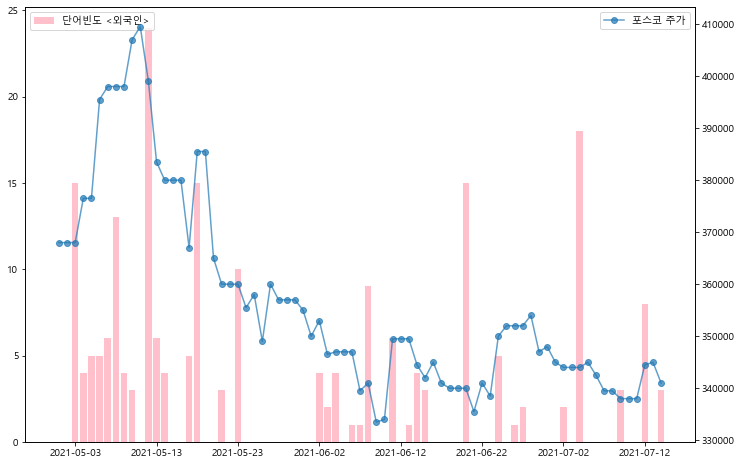

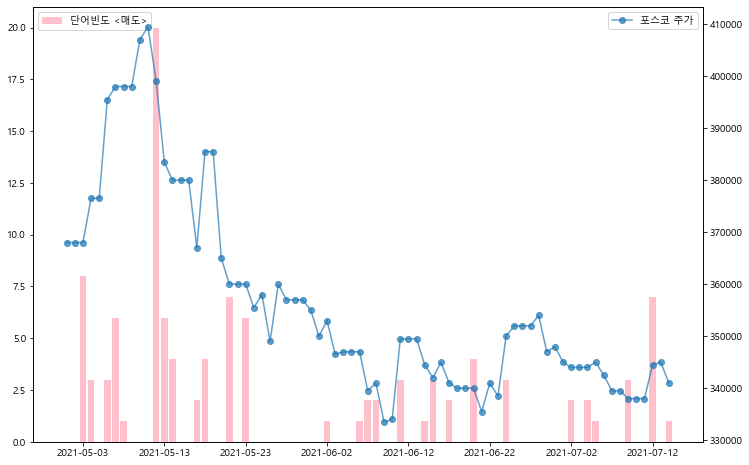

In [18]:
# 검색결과 주가 확인- 키워드 영향력 찾기
start_date = '2021-05-01'
end_date = '2021-07-14'
주가확인_v3('포스코','외국인',제목5내용6=6)
주가확인_v3('포스코','매도',제목5내용6=6)